# Customs Frauds Detection with Python

## BACUDA Series
## How to use DATE for interpretate results

### Yu-Che Tsai (roytsai27 @gmail.com), Department of Statistics, National Cheng Kung University

## Short Summary
> DATE first takes a set of leaf-node from the pre-trained XGBoost classifier as input. <br>
It then applies attention mechanism by incorporating the use embedding and HS6 code embedding. <br>
The attention mechanism was used to dynamically assign weights to each leaf-node(i.e. cross-features), leaf-nodes with a higher weights means it contribute more to our prediction results.<br>
After we trained DATE on a specific dataset, we could feed unseen data and observe the attention distribution to find out which cross-feature contribute more to our prediction.

## Requirements
* A trained XGBoost classifer, which should be saved aftering training (should be a .txt file).
* A trained DATE model, saved with .pkl file.
* leaf_index.pickle to be used for projecting leaf-index to tree structure.
* Dataset to analysis, could be either training data or test data.

## Dataset
* The transaction level from Nigera dataset from 2013~2017
* Since we have already trained DATE with a set of training data(i.e. 2013 to 2016), we only anaylze the testing set in this notebook.


## Guideline
1. Load the pre-trained XGBoost Classifier to obtain the leaf-node(cross features).<br>
2. Load the trained DATE model
3. Convert the dataset into torch tensors 
4. Use DATE(data) to get prediction outputs
4. Since Neural Networks in pytorch are store in python **class** format, we could obtain attention weight by calling "model.attention_w" attribute. 

## Data preparation

In [1]:
# load packages
import pickle
import numpy as np
import torch
import torch.utils.data as Data
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
# load preprocessed dataset
with open("./processed_data.pickle","rb") as f:
    processed = pickle.load(f)
test = processed["raw"]["test"]
test = test.reset_index(drop=True) # raw data(test set)

### Load DATE model and testing set with torch format
Note that the torch_data.pickle file was created by generate_loader.py. <br>
Since DATE is implemented pytorch, the input data for DATE should be converted into **torch.tensor**. <br>
We use "dataloader" in torch to split test data into small batches to avoid memory error(out of memory).

In [3]:
# load DATE model
model = torch.load("./saved_models/DATE_0.7467.pkl").module

# load torch dataset 
with open("../torch_data.pickle","rb") as f:
    data = pickle.load(f)
test_dataset = data["test_dataset"]

# create dataloader
batch_size = 256 # the data size per batch
test_loader = Data.DataLoader( # Note that you could iterate dataloader with for loop to obtain batches
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

### Obtain attention weights for each transaction
Each transaction is given as the input for XGBoost model and output the **index** of leaf-nodes.<br>
Therfore, if the XGBoost is built with N trees, there would be a list of N index from XGBoost.<br>
Based on previous results, DATE further learns attentive weights for each leaf-node(cross-feature).<br>
Therefore, there would be N attentive weights given a single transaction with it's corresponding leaf-nodes. Note that the summation of weights is equals 1.

In [4]:
attention_weight = [] # create a list to store attention weights for each transaction
predicted_illicit_prob = []
predicted_rev = []
device = model.device # the device id of model and data should be consistant

# iterate over test data
for batch_feature,batch_user,batch_item,batch_cls,batch_reg in test_loader:
    model.eval() # this line is to set the model for evaluation stage by stoping some parameters(e.g. dropout)
    
    # convert the data into same device as our model 
    batch_feature,batch_user,batch_item,batch_cls,batch_reg =  \
    batch_feature.to(device), batch_user.to(device), batch_item.to(device),\
     batch_cls.to(device), batch_reg.to(device)
    batch_cls,batch_reg = batch_cls.view(-1,1), batch_reg.view(-1,1)

    # model output
    classification_output, regression_output, hidden_vector = model(batch_feature,batch_user,batch_item) # get the prediction output
    
    # convert torch.tensor to numpy array
    classification_output = classification_output.detach().cpu().numpy()
    regression_output = regression_output.detach().cpu().numpy()
    att_w = model.attention_w.detach().cpu().numpy()
    att_w = att_w.reshape(-1,100)
    
    attention_weight.extend(att_w.tolist())
    predicted_illicit_prob.extend(classification_output.ravel().tolist())
    predicted_rev.extend(regression_output.ravel().tolist())

# conver python list to numpy array
attention_weight = np.array(attention_weight)
predicted_illicit_prob = np.array(predicted_illicit_prob)
predicted_rev = np.array(predicted_rev)

###  Averaged attention weight visualization
After obtaining attention weights among all of the test set, we could average the weights and observe the distribution of weights.

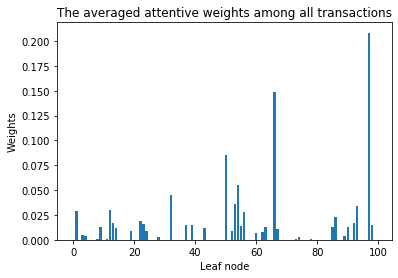

In [5]:
plt.bar(range(100),attention_weight.mean(axis=0))
plt.xlabel("Leaf node")
plt.ylabel("Weights")
plt.title("The averaged attentive weights among all transactions")
plt.show()

## Sample transactions
Due to the great amount of transactions, we sample 1 licit and 1 illicit transaction for demonstration.

In [6]:
number_sampled = 1
illicit_sample = test[test.illicit==1].sample(number_sampled,random_state=1) # sample from illicit samples
transaction_id = illicit_sample.index[0] # get the index of sampled data
print("Index of sampled data:",transaction_id)

Index of sampled data: 118239


In [7]:
illicit_sample

,YEAR,OFFICE,SGD.NUMBER,SGD.DATE,RECEIPT.NUMBER,RECEIPT.DATE,IMPORTER.TIN,DECLARANT.CODE,FOB.VALUE,CIF.VALUE,...,RiskH.TARIFF.DESCRIPTION,RiskH.TARIFF.CODE,RiskH.QUANTITY,RiskH.HS6,RiskH.HS4,RiskH.HS2,RiskH.OFFICE,RiskH.OFFICE&IMPORTER.TIN,RiskH.OFFICE&HS6,RiskH.OFFICE&ISO3
118239,2017,OFFICE91,SGD922876,17-11-28,RCP916239,17-12-04,IMP600519,DEC685844,7033400.0,8335191.0,...,0,0,0,0,0,0,0,1,0,0


### Take a look at the inspection information

In [8]:
print("Checking the inspection information of sampled data")
print("-"*52)
for text in illicit_sample['INSPECTION.INFORMATION'].values:
    print(text.strip())
    print("-"*52)

Checking the inspection information of sampled data
----------------------------------------------------














AC AGHOLOR A.I
----------------------------------------------------


## Analyze attention weight with XGBoost leaf-nodes

In [9]:
# load leaf_index dictionary to project lead-id into XGBoost tree structure
with open("leaf_index.pickle","rb") as f:
    leaf_index = pickle.load(f)

In [10]:
# first, take a look at the prediction probability of the transaction
print("Prediction probability:%.4f" % predicted_illicit_prob[transaction_id])
top_k = 5 # number of cross feature to observe (select top k)
test_leaves = test_dataset.tensors[0].numpy() # the leaf index for all transactions
tree_id = np.argsort(attention_weight[transaction_id])[-top_k:] # obtain which trees have the hightest weights
print("Trees with the highest attention weights:",tree_id)
leaf_id = [test_leaves[transaction_id][i] for i in tree_id] # obtain the leaf-id for the trees
print("The corresponding index of the leaf node:",leaf_id)

# transform the leaf index to the original XGBoost tree structure
# Variable leaf_index is a dictionary with {leaf-id: {tree-id,node-id}}
xgb_cross_feature = [leaf_index[l] for l in leaf_id] 
print("The node id in the original XGBoost model:",xgb_cross_feature)

Prediction probability:0.9994
Trees with the highest attention weights: [98 32 13 12 28]
The corresponding index of the leaf node: [1548, 504, 195, 179, 440]
The node id in the original XGBoost model: [{98: 20}, {32: 30}, {13: 25}, {12: 23}, {28: 30}]


In [11]:
# read the contents of the file
with open('xgb_model2.txt', 'r') as f:
    txt_model = f.read()

# Note: To maintain the clearness, only print the result for the first tree. Please print the whole text data when analyzing by yourself
print(txt_model[:1015]) 

booster[0]:
0:[TaxRatio<0.00182044168] yes=1,no=2,missing=1
	1:[TaxUnitquantity<22.8490429] yes=3,no=4,missing=3
		3:[TOTAL.TAXES<6823.5] yes=7,no=8,missing=7
			7:leaf=0.199860305
			8:leaf=0.0500000007
		4:[RiskH.OFFICE&IMPORTER.TIN<0.5] yes=9,no=10,missing=9
			9:[EXCHANGERATE<170.26001] yes=15,no=16,missing=15
				15:leaf=-0.162500009
				16:leaf=-0
			10:[GROSS.WEIGHT<34460] yes=17,no=18,missing=17
				17:leaf=0.150000006
				18:leaf=-0
	2:[RiskH.OFFICE&IMPORTER.TIN<0.5] yes=5,no=6,missing=5
		5:[CIF.VALUE<700005.5] yes=11,no=12,missing=11
			11:[RiskH.OFFICE&HS6<0.5] yes=19,no=20,missing=19
				19:leaf=-0.199470758
				20:leaf=-0.184831649
			12:[TaxRatio<0.437450051] yes=21,no=22,missing=21
				21:leaf=-0.195282146
				22:leaf=-0.198604077
		6:[RiskH.HS6.Origin<0.5] yes=13,no=14,missing=13
			13:[FOBCIFRatio<0.999917626] yes=23,no=24,missing=23
				23:leaf=-0.171607345
				24:leaf=-0.119938411
			14:[TaxRatio<0.280007631] yes=25,no=26,missing=25
				25:leaf=-0.0613040626
				26:

## Extract dicision path
From the previous cell, we could see that the tree structure is revealed. "**booster[id]**" denotes the tree id and follows with it's node id of each leaf-node.<br>
We have already obtain the leaf-node and their tree-id is [{98: 20}, {32: 30}, {13: 25}, {12: 23}, {28: 30}].<br>
Therefore, we would have decision paths for each leaf-node regrarding to the text file.

Prediction probability:0.9994<br>
Trees with the highest attention weights: [98 32 13 12 28]<br>
The corresponding index of the leaf node: [1548, 504, 195, 179, 440]<br>
The node id in the original XGBoost model: [{98: 20}, {32: 30}, {13: 25}, {12: 23}, {28: 30}]

### Decision Paths
* Leaf_id: 1548, Tree id: 98, Node id: 20 <br>
path: [20<-9<-4<-1<-0] <br>
cross feature: RiskH.OFFICE&IMPORTER.TIN>0.5 | TaxRatio<0.111423187 | TaxRatio>0.0686226115 | RiskH.QUANTITY<0.5
* Leaf_id: 504, Tree id: 32, Node id:30 <br>
path: [30<-14<-6<-2<-0] <br>
cross feature: GROSS.WEIGHT>6047.4502 | SGD.DayofYear>460.5 | TaxRatio>0.00499979965 |RiskH.OFFICE&IMPORTER.TIN>0.5
* Leaf_id: 195, Tree id: 13, Node id:25 <br>
path: [25<-12<-5<-2<-0] <br>
cross feature: FOBCIFRatio<0.999917626 | TaxRatio<0.0634894818 | RiskH.HS6.Origin<0.5 | RiskH.OFFICE&IMPORTER.TIN>0.5
* Leaf_id: 179, Tree id: 12, Node id:23 <br>
path: [23<-12<-5<-2<-0] <br>
cross feature: FOBCIFRatio<0.999916792 | RiskH.IMPORTER.TIN>0.5 | RiskH.OFFICE&HS6<0.5 | RiskH.OFFICE&IMPORTER.TIN>0.5
* Leaf_id: 440, Tree id: 28, Node id:30 <br>
path: [30<-14<-6<-2<-0] <br>
cross feature: TARIFF.CODE>2.50100147e+09 | TOTAL.TAXES>20007 | RiskH.DECLARANT.CODE>0.5 | RiskH.OFFICE&IMPORTER.TIN>0.5